## Install and Import Libraries

In [ ]:
!pip install huggingface_hub
!pip install transformers
!pip install transformers[torch]
!pip install datasets
!pip install shap
!pip install torchmetrics
from datasets import load_dataset, load_dataset_builder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Recall, Precision
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall
import random
# Set Random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.1 MB/s eta 0:00:00


## Load the Dataset

In [ ]:
dataset_name = "saifhmb/FraudPaymentData"
ds_builder = load_dataset_builder(dataset_name)
ds_builder.info

README.md:   0%|          | 0.00/772 [00:00<?, ?B/s]

DatasetInfo(description='', citation='', homepage='', license='', features={'Time_step': Value('string'), 'Transaction_Id': Value('string'), 'Sender_Id': Value('string'), 'Sender_Account': Value('string'), 'Sender_Country': Value('string'), 'Sender_Sector': Value('float64'), 'Sender_lob': Value('string'), 'Bene_Id': Value('string'), 'Bene_Account': Value('string'), 'Bene_Country': Value('string'), 'USD_amount': Value('float64'), 'Label': Value('int64'), 'Transaction_Type': Value('string')}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='fraud_payment_data', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=181410381, num_examples=1048575, shard_lengths=None, dataset_name=None)}, download_checksums=None, download_size=44493051, post_processing_size=None, dataset_size=181410381, size_in_bytes=None)

In [ ]:
dataset = load_dataset(dataset_name, split = 'train')

data/train-00000-of-00001.parquet:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1048575 [00:00<?, ? examples/s]

In [ ]:
dataset = pd.DataFrame(dataset)
dataset.head()

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,3/15/2022 10:24,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,None,None,None,558.43,0,WITHDRAWAL
1,3/15/2022 10:24,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,3/15/2022 10:24,DEPOSIT-CASH-9833,None,None,None,NaN,None,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,3/15/2022 10:24,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,3/15/2022 10:24,DEPOSIT-CHECK-9806,None,None,None,NaN,None,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK


# EDA

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1048575 non-null  object 
 1   Transaction_Id    1048575 non-null  object 
 2   Sender_Id         895299 non-null   object 
 3   Sender_Account    895299 non-null   object 
 4   Sender_Country    895299 non-null   object 
 5   Sender_Sector     895299 non-null   float64
 6   Sender_lob        895299 non-null   object 
 7   Bene_Id           897641 non-null   object 
 8   Bene_Account      897641 non-null   object 
 9   Bene_Country      897641 non-null   object 
 10  USD_amount        1048575 non-null  float64
 11  Label             1048575 non-null  int64  
 12  Transaction_Type  1048575 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 104.0+ MB


In [ ]:
print(f"Dataset shape before dropping NaNs: {dataset.shape}")
dataset.dropna(inplace=True)
print(f"Dataset shape after dropping NaNs: {dataset.shape}")
dataset.info()

In [ ]:
dataset['Time_step'].describe()

,Time_step
count,744365
unique,382275
top,11/20/2034 16:35
freq,73


In [ ]:
dataset['Time_step'] = pd.to_datetime(dataset['Time_step'])

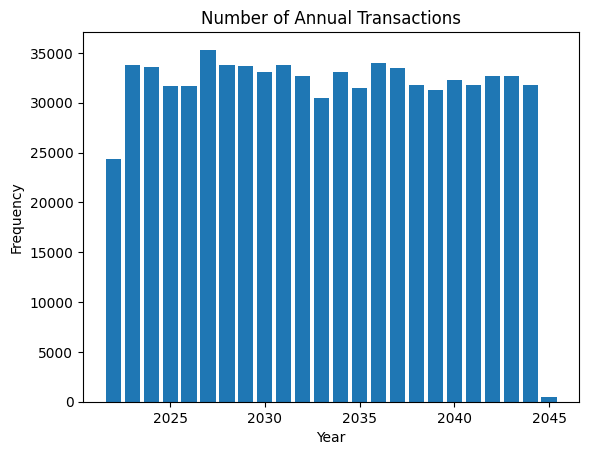

In [ ]:
year_counts = dataset['Time_step'].dt.year.value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Annual Transactions')
plt.show()

In [ ]:
dataset['Transaction_Id'].describe()

,Transaction_Id
count,744365
unique,744365
top,PAY-CHECK-1536827
freq,1


In [ ]:
# All the values of Transaction_Id are unique. Therefore, it is a high cardinality feature

In [ ]:
dataset['Sender_Id'].describe()

,Sender_Id
count,744365
unique,40957
top,JPMC-CLIENT-303611
freq,132


In [ ]:
dataset['Sender_Account'].describe()

,Sender_Account
count,744365
unique,51917
top,ACCOUNT-58253
freq,74


In [ ]:
dataset['Sender_Country'].describe()

,Sender_Country
count,744365
unique,252
top,USA
freq,564266


In [ ]:
dataset['Sender_Sector'].describe()

,Sender_Sector
count,744365.000000
mean,25024.607663
std,14429.958803
min,0.000000
25%,12551.000000
50%,25026.000000
75%,37532.000000
max,49999.000000


In [ ]:
dataset['Sender_lob'].describe()

,Sender_lob
count,744365
unique,1
top,CCB
freq,744365


In [ ]:
# Sender_lob has a single unique value so this can be DROPPED

In [ ]:
dataset['Bene_Id'].describe()

,Bene_Id
count,744365
unique,194651
top,CLIENT-1029620
freq,61


In [ ]:
dataset['Bene_Account'].describe()

,Bene_Account
count,744365
unique,205268
top,ACCOUNT-1029621
freq,61


In [ ]:
dataset['Bene_Country'].describe()

,Bene_Country
count,744365
unique,252
top,USA
freq,395722


In [ ]:
dataset['USD_amount'].describe()

,USD_amount
count,744365.000000
mean,510.397698
std,543.078385
min,0.000000
25%,100.700000
50%,400.450000
75%,723.130000
max,19927.990000


In [ ]:
dataset['Label'].value_counts()

,count
Label,
0,728983
1,15382


## 0 is non-fraudulent and 1 is fraudulent

In [ ]:
dataset['Transaction_Type'].describe()

,Transaction_Type
count,744365
unique,4
top,MAKE-PAYMENT
freq,390511


In [ ]:
dataset = dataset.drop(['Transaction_Id', 'Sender_lob', 'Sender_Sector', 'Sender_Id', 'Bene_Id'], axis = 1) #  deleting features with high cardinality and no variance
dataset.head(1)

,Time_step,Sender_Account,Sender_Country,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
1,2022-03-15 10:24:00,ACCOUNT-10109,USA,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT


# Feature Engineering
## Convert Time_step to Month, Weekday, Hour, and AM/PM

In [ ]:
dataset['Month'] = dataset['Time_step'].dt.month

In [ ]:
dataset['Weekday'] = dataset['Time_step'].dt.strftime('%a')

In [ ]:
dataset['Hour'] = dataset['Time_step'].dt.hour

In [ ]:
dataset['AMorPM'] = np.where(dataset['Hour'] <12, 'AM', 'PM')

In [ ]:
dataset = dataset.drop(['Time_step'], axis = 1)

In [ ]:
dataset.head(1)

,Sender_Account,Sender_Country,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Month,Weekday,Hour,AMorPM
1,ACCOUNT-10109,USA,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,3,Tue,10,AM


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744365 entries, 1 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sender_Account    744365 non-null  object 
 1   Sender_Country    744365 non-null  object 
 2   Bene_Account      744365 non-null  object 
 3   Bene_Country      744365 non-null  object 
 4   USD_amount        744365 non-null  float64
 5   Label             744365 non-null  int64  
 6   Transaction_Type  744365 non-null  object 
 7   Month             744365 non-null  int32  
 8   Weekday           744365 non-null  object 
 9   Hour              744365 non-null  int32  
 10  AMorPM            744365 non-null  object 
dtypes: float64(1), int32(2), int64(1), object(7)
memory usage: 62.5+ MB


## Encoding Categorical data and Feature Scaling

### Encoding the Independent Variables and Applying Feature Scaling

In [ ]:
dataset.select_dtypes(include=np.number).head(1)

,USD_amount,Label,Month,Hour
1,622.78,0,3,10


In [ ]:
categoricalColumns = ['Sender_Account', 'Sender_Country', 'Bene_Account', 'Bene_Country', 'Transaction_Type', 'Month', 'Weekday', 'Hour', 'AMorPM']




In [ ]:
numericalColumns = ['USD_amount']

In [ ]:
y_col = ['Label']

In [ ]:
for category in categoricalColumns:
  dataset[category] = dataset[category].astype('category')

In [ ]:
dataset['USD_amount'] = dataset['USD_amount'].astype('float32')

In [ ]:
categoricalColumns_stack = np.stack([dataset[col].cat.codes.values for col in categoricalColumns], axis =1)

In [ ]:
categoricalColumns_stack

array([[   411,    239,   1591, ...,      5,     10,      0],
       [ 51253,    239, 202632, ...,      5,     10,      0],
       [ 51061,    239, 201838, ...,      5,     10,      0],
       ...,
       [ 20096,      8,  79184, ...,      0,      9,      0],
       [ 20084,    239,  79149, ...,      0,      9,      0],
       [ 20063,    239,  79117, ...,      0,      9,      0]], dtype=int32)

In [ ]:
categoricalColumns_stack = torch.tensor(categoricalColumns_stack)

In [ ]:
numericalColumns_stack = np.stack([dataset[col].values for col in numericalColumns], axis = 1)
numericalColumns_stack = torch.tensor(numericalColumns_stack, dtype=torch.float32) # Convert to float32 here

In [ ]:
numericalColumns_stack = torch.tensor(numericalColumns_stack)
numericalColumns_stack

/tmp/ipython-input-3922840964.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  numericalColumns_stack = torch.tensor(numericalColumns_stack)


tensor([[622.7800],
        [989.0900],
        [543.8700],
        ...,
        [595.0500],
        [233.7200],
        [833.6500]])

In [ ]:
y = torch.tensor(dataset[y_col].values, dtype=torch.float32)

In [ ]:
categoricalColumns_stack.shape

torch.Size([744365, 9])

In [ ]:
numericalColumns_stack.shape

torch.Size([744365, 1])

In [ ]:
y.shape

torch.Size([744365, 1])

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# Combine categorical and numerical features into a single array for resampling
X_combined = torch.cat((categoricalColumns_stack.cpu(), numericalColumns_stack.cpu()), dim=1).numpy()
y_combined = y.cpu().numpy().flatten()

under_sampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = under_sampler.fit_resample(X_combined, y_combined)

# Split X_resampled back into categorical and numerical parts
categoricalColumns_stack = torch.tensor(X_resampled[:, :categoricalColumns_stack.shape[1]], dtype=torch.long)
numericalColumns_stack = torch.tensor(X_resampled[:, categoricalColumns_stack.shape[1]:], dtype=torch.float32)
y = torch.tensor(y_resampled, dtype=torch.float32).unsqueeze(1)

print(f"Shape after undersampling: Categorical features: {categoricalColumns_stack.shape}, Numerical features: {numericalColumns_stack.shape}, Labels: {y.shape}")
print(f"New class distribution: {np.unique(y_resampled, return_counts=True)}")

Shape after undersampling: Categorical features: torch.Size([30764, 9]), Numerical features: torch.Size([30764, 1]), Labels: torch.Size([30764, 1])
New class distribution: (array([0., 1.], dtype=float32), array([15382, 15382]))


## Embedding Layers  - This is the equivalent of one-hot encoding

In [ ]:
category_size = [len(dataset[col].cat.categories) for col in categoricalColumns] # provides number of unique categories
category_size

[51917, 252, 205268, 252, 4, 12, 7, 24, 2]

In [ ]:
# Rule of thumb -  divide number of categories by 2 but do NOT exceed 50 embeddings
embedding_size = [(size, min(50, (size +1)//2)) for size in category_size]

## Creating a Neural Network

In [ ]:
class Net(nn.Module):
  def __init__(self, embedding_size, numerical_features, out_size, layers, p ): # p = 0.5 is the probability for dropout layer
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(num_cat, num_embedding) for num_cat, num_embedding in embedding_size])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(numerical_features) # normalizing the numerical/continuous values

    layerlist = []
    n_emb = sum([num_embedding for num_cat, num_embedding in embedding_size])
    n_in = n_emb + numerical_features
    for i in layers:
      layerlist.append(nn.Linear(n_in, i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i

    layerlist.append(nn.Linear(layers[-1],out_size))
    self.layers = nn.Sequential(*layerlist)
    self.sigmoid = nn.Sigmoid() # Add sigmoid activation

  def forward(self, cat_features, num_features):
    embeddings = []
    for i,e in enumerate(self.embeds):
      embeddings.append(e(cat_features[:,i]))
    x = torch.cat(embeddings,1)
    x = self.emb_drop(x)
    num_features = self.bn_cont(num_features)
    x = torch.cat([x, num_features], 1)
    x = self.layers(x)
    x = self.sigmoid(x) # Apply sigmoid activation here
    return x

In [ ]:
numericalColumns_stack.shape[1]

1

In [ ]:
model = Net(embedding_size=embedding_size, numerical_features = numericalColumns_stack.shape[1],
 out_size = 1, layers = [(numericalColumns_stack.shape[1]+categoricalColumns_stack.shape[1]), int(1.5 *(numericalColumns_stack.shape[1]+categoricalColumns_stack.shape[1]))],
            p = 0.05)

In [ ]:
model

Net(
  (embeds): ModuleList(
    (0): Embedding(51917, 50)
    (1): Embedding(252, 50)
    (2): Embedding(205268, 50)
    (3): Embedding(252, 50)
    (4): Embedding(4, 2)
    (5): Embedding(12, 6)
    (6): Embedding(7, 4)
    (7): Embedding(24, 12)
    (8): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.05, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=226, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=10, out_features=15, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=15, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()
optimizer =torch.optim.Adam(model.parameters(), lr =0.0001, betas =(0.99, 0.999))

## Splitting the dataset into the Training set and Test set

In [ ]:
batch_size = int(categoricalColumns_stack.shape[0])
test_size = int(batch_size * 0.15)
print(f'batch size is {batch_size}')
print(f'test size is {test_size}')

batch size is 30764
test size is 4614


In [ ]:

categorical_train = categoricalColumns_stack[:batch_size-test_size]
categorical_test = categoricalColumns_stack[batch_size-test_size:batch_size]
numerical_train = numericalColumns_stack[:batch_size-test_size]
numerical_test = numericalColumns_stack[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
len(categorical_train)

26150

In [ ]:
len(categorical_test)

4614

## Train the model

In [ ]:
import time
start_time = time.time()
epochs = 5000
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(categorical_train, numerical_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item()) # Store the scalar value of the loss

    if i%100==0:
      print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.0f} minutes') #

epoch: 100  loss: 0.07322268
epoch: 200  loss: 0.07212292
epoch: 300  loss: 0.06782370
epoch: 400  loss: 0.06422486
epoch: 500  loss: 0.06425308
epoch: 600  loss: 0.06130827
epoch: 700  loss: 0.05853618
epoch: 800  loss: 0.06019238
epoch: 900  loss: 0.05689839
epoch: 1000  loss: 0.05669077
epoch: 1100  loss: 0.05652986
epoch: 1200  loss: 0.05557622
epoch: 1300  loss: 0.05053839
epoch: 1400  loss: 0.05261915
epoch: 1500  loss: 0.04970901
epoch: 1600  loss: 0.04919778
epoch: 1700  loss: 0.05094766
epoch: 1800  loss: 0.04897426
epoch: 1900  loss: 0.04639462
epoch: 2000  loss: 0.04572109
epoch: 2100  loss: 0.04430007
epoch: 2200  loss: 0.04725635
epoch: 2300  loss: 0.04251219
epoch: 2400  loss: 0.04511770
epoch: 2500  loss: 0.04340472
epoch: 2600  loss: 0.04211937
epoch: 2700  loss: 0.04103118
epoch: 2800  loss: 0.04060427
epoch: 2900  loss: 0.03953188
epoch: 3000  loss: 0.03967654
epoch: 3100  loss: 0.03865768
epoch: 3200  loss: 0.03828355
epoch: 3300  loss: 0.03821146
epoch: 3400  loss: 

## Predicting the Test set results

In [ ]:
with torch.no_grad():
  y_val = model(categorical_test, numerical_test)
  loss = criterion(y_val, y_test)

print(f'CE Loss: {loss:.8f}')

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')

In [ ]:
binary_accuracy = BinaryAccuracy(threshold=0.5)
binary_accuracy(y_val, y_test)